# Predictions & Data Modeling

### Goals

The goal of this notebook is to build from previous notebooks and add a step-by-step method for predicting the classifications of textual data. That is, if you have texts that are classified in some way (like real or fake news), then you can use this notebook to train a model that can predict whether a new, unseen article is real or fake. While there are more advance methods in development, text classification and prediction continues to be one of the most reliable modes of computational text analysis.

As with previous (and any) kind of text analysis, it's important to be cautious with your results. Our goal with these notebooks is not to learn something about fake or real news, though it's fine to speculate. Rather, the goal is to learn how to write code that will allow you to pursue your own research questions.

#### Brief Note about Libraries
Below, you'll notice that we're importing a lot of libraries and packages. Although it looks like a lot, they all come from a few of the following libraries, which you can get with a conda installation:

New Libraries in this Notebook:
1. numpy (conda install -c anaconda numpy)
2. scipy (conda install -c anaconda scipy)

Older Libraries:
1. re
2. pandas
3. seaborn
4. matplot
5. sklearn

As I mentioned earlier in these notebooks, if you want to use computational methods to think through a research question, odds are the code is already somewhere online. This notebook is an example of finding and re-using code. The majority of the code here was copied and developed from Susan Li's explanation and tutorial, linked to below.

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import sklearn libraries for prediction/modeling.
from scipy import stats

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

abs_dir = "/Users/williamquinn/Desktop/DH/Python/Teaching/Python-Notebooks/"

## Multi-class Text Classification

Multi-class refers to determining the probability that a variable is one option out of a few. In this exercise, we're trying to predict the correct class from two options, real or fake news.

The following cell does the important work of declaring a class (or column) to predict, in this case 'veracity.' We're creating a variable, "class_to_predict," so that we can easily change one line of code rather than searching for multiple lines. That is, if we want to try predicting a different column, we can change one string variable here that we'll call a number of times rather than changing every instance that variable is needed.

In [2]:
data = pd.read_csv(abs_dir + "data/dataframe.csv",
                   sep = ",")

# Declare class to predict.
class_to_predict = "veracity"

# Create labels.
labels = data[str(class_to_predict)]

data.head()

,title,text,subject,date,veracity,dataset
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,real,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,real,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,real,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,real,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,real,0


The following code is nearly identical to the last notebook. I've consolidated the code into a single cell here to streamline a little.

In [3]:
%%time

# Clean up text field.
data['text'] = data['text'] \
    .replace(r"[A-Z/]+ \(\w+\) - ", "", regex=True) \
    .replace(r'\s+', ' ', regex=True) \
    .str.lower() \
    .astype(str)

# Instantiate a vectorizer.
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=0.1, 
                        max_df=0.9, 
                        stop_words='english',
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))

features = tfidf.fit_transform(data['text']).toarray()

# Show data size.
features.shape

CPU times: user 1min 37s, sys: 3.92 s, total: 1min 41s
Wall time: 1min 44s


(57887, 202)

## Model Testing

https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f

Now that we have transformed our text to numeric representations we can begin modeling our data.

For our purposes, data modeling refers to 
Explanation/descriptions of data modeling...

There are different classifiers to chose from and they each vary in their effectiveness. This cell helps determine which model we'll want to pick. After evaluating the cross validation of each model, the cell prints a visualization and brief accuracy report.

Key Terms:
* Cross Validation: Cross validation is a method to evaluate a model.

Many algorithms split a dataset into a training portion and a testing portion. An algorithm will try to learn what features distinguish one class from another within the training portion. The model, then, is meant to represent the classes it found within the dataset. With the model now trained, the testing portion will provide a sense of how accurate the model is. The model guesses the class of each observation within the testing set, making guesses on the significant features it has found. The testing set hides the correct answer from the model until it has made all its guesses and then can measure how accurate the model was.

The "accuracy" of a model is a reflection of the dataset itself. In our dataset, we will get a sense of how accurate these models can determine whether an article is fake or real. But, if we're being precise, we would need to add: we get a sense of how accurate these models are at guessing observations already within the dataset. Observations from another dataset might change the "accuracy" of the model.

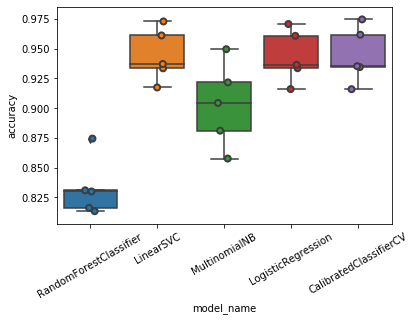

CPU times: user 1min 27s, sys: 2.15 s, total: 1min 29s
Wall time: 1min 19s


model_name
CalibratedClassifierCV    0.944339
LinearSVC                 0.944322
LogisticRegression        0.943424
MultinomialNB             0.902776
RandomForestClassifier    0.832915
Name: accuracy, dtype: float64

In [4]:
%%time

# Declare a list of models to evaluate. 
# Some models have their own arguments.
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    CalibratedClassifierCV(base_estimator = LinearSVC())
]

# Set up cross validation.
CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

# Measure accuracy of models and create dataframe of results.
entries = []

# Iterate through list of models, measuring accuracy of each.
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Create a dataframe of accuracy results.
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Visualize model accuracy.
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=6, jitter=True, edgecolor="gray", linewidth=2)

# Rotate axis labels.
plt.xticks(rotation=30)
plt.show()

# Print accuracy report.
cv_df.groupby('model_name').accuracy.mean()

### Model Evaluation

It looks like the <b>CalibratedClassifierCV</b> has the highest accuracy and would be preferable than the <b>RandomForestClassifier</b>. But, the models above behave differently. Their different functionalities might constrain how you access them and/or try to transform the data within. For example, if you use <b>LinearSVC()</b> below, you'll run into an AttributeError ('LinearSVC' object has no attribute 'predict_proba') in the subsequent cell. If the accuracy score is negligible, you might choose a model that you're more familiar with. Additionally, if you were doing scholarly research, you might choose a model for more specialized reasons.

In [7]:
%%time

# Declare classifier (clf). Calibrated requires argument.
# If you want to use another model, simply change the following line to: clf = the model you'd like to use
clf = CalibratedClassifierCV(base_estimator = LinearSVC())

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                                 labels, 
                                                                                 data.index, 
                                                                                 test_size=0.33, 
                                                                                 random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Print accuracy report.
print(metrics.classification_report(y_test, 
                                    y_pred,
                                    labels = labels.unique()))

# Print cross validation report.
cross_val_svc = cross_val_score(estimator = clf, 
                                X = X_train, y = y_train, cv = 10, n_jobs = -1)

print("Cross Validation Accuracy : ", round(cross_val_svc.mean() * 100 , 2), "%\n",
      '\n', clf.predict_proba(features).shape)

              precision    recall  f1-score   support

        real       0.93      0.95      0.94      7046
        fake       0.97      0.96      0.96     12057

    accuracy                           0.96     19103
   macro avg       0.95      0.95      0.95     19103
weighted avg       0.96      0.96      0.96     19103

Cross Validation Accuracy :  95.35 %
 
 (57887, 2)
CPU times: user 4.01 s, sys: 526 ms, total: 4.54 s
Wall time: 27.8 s


The report printed above indicates that are model is incredibly accurate. But, this report provides a holistic and zoomed-out view. What if we want a 

## Probabilities of Each Predicted Class

While above gives us an overview of our model (and the accuracy of predicting fake and real news), we can't learn much from this report. Merging the prediction results with metadata will allows us see a breakdown of every article and to examine trends over time.

In [11]:
%%time

# Print size of class probabilities.
# Calls back features variable (tf-idf results).
print (clf.predict_proba(features).shape)

# Return predicted class probabilities of original dataframe.
predictions = pd.DataFrame((clf.predict_proba(features)*100),
                           index = data.index,
#                            I have set columns manually because of a bug I wasn't able to resolve...
#                            Normally, this can be set using labels.unique()
                           columns = ['fake', 'real']) \
    .reset_index()

# Merge prediction results with metadata.
results = pd.merge(data, predictions, 
                   how = "inner", left_index = True, right_index = True)

# results = results.drop(["text", "class_id"], axis = 1)
results = results.drop(["text"], axis = 1) 

results = pd.melt(results,
                  id_vars = ['title', 'veracity', 'date'],
                  value_vars = labels.unique(),
                  var_name = 'predicted_veracity',
                  value_name = 'prediction') \
    .reset_index()

results.head()

(57887, 2)
CPU times: user 451 ms, sys: 46.7 ms, total: 497 ms
Wall time: 336 ms


,index,title,veracity,date,predicted_veracity,prediction
0,0,"As U.S. budget fight looms, Republicans flip t...",real,2017-12-31,real,99.656096
1,1,U.S. military to accept transgender recruits o...,real,2017-12-29,real,95.773286
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,real,2017-12-31,real,18.568696
3,3,FBI Russia probe helped by Australian diplomat...,real,2017-12-30,real,82.502171
4,4,Trump wants Postal Service to charge 'much mor...,real,2017-12-29,real,80.667455


Because we have nearly 60,000 documents over a few years, we'll want to find the average and standard deviation of predictions.

In [31]:
results \
    .groupby(['veracity', 'predicted_veracity'])['prediction'].mean()

results['date'] = pd.to_datetime(results['date'])
results['year'] = results['date'].dt.year

averages = results \
    .query('veracity == predicted_veracity') \
    .groupby(['year', 'predicted_veracity'])['prediction'] \
    .mean() \
    .reset_index()

averages.head()

,year,predicted_veracity,prediction
0,2015,fake,89.512751
1,2016,fake,95.164698
2,2016,real,86.288479
3,2017,fake,93.605737
4,2017,real,91.654498


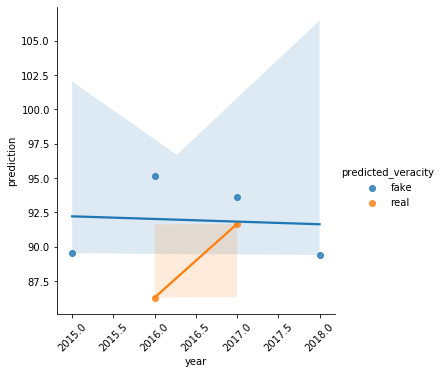

In [32]:
ax = sns.lmplot(data = averages,
                x = 'year', y = 'prediction', hue = 'predicted_veracity')

ax.set_xticklabels(rotation=45)

## Conclusion



#### Works Cited

* Li, Susan. "[Multi-Class Text Classification with Scikit-Learn](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)." <i>towards data science</i>, February 19, 2018. Accessed: February 9, 2020.

* ____. "[Machine Learning with Python](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb)." GitHub. Accessed: February 9, 2020.

* Saxena, Manoveg. "[predicting_probabilities_with_linearSVC.ipynb](https://github.com/manoveg/ML_with_python/blob/master/predicting_probabilities_with_linearSVC.ipynb)." GitHub. Accessed: February 9, 2020.

* Z., Zahash. "[A Simple Guide to creating Predictive Models in Python, Part-2a](https://medium.com/datadriveninvestor/a-simple-guide-to-creating-predictive-models-in-python-part-2a-aa86ece98f86)." <i>Medium</i>, November 22, 2018. Accessed: February 9, 2020.